In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Load Dataset

In [2]:
def fetch_iwm_data():
    iwm = yf.Ticker("IWM")
    data = iwm.history(period="max")  # Adjust the period as needed
    return data

In [3]:
iwm_data = fetch_iwm_data()

In [4]:
# Display the first few rows of the dataset
print(iwm_data.head())

# Basic information about data types and missing values
print(iwm_data.info())

# Descriptive statistics
print(iwm_data.describe())


                                Open       High        Low      Close  Volume  \
Date                                                                            
2000-05-26 00:00:00-04:00  33.261803  33.398777  33.102000  33.398777   74800   
2000-05-30 00:00:00-04:00  33.878194  34.631550  33.878194  34.631550   57600   
2000-05-31 00:00:00-04:00  34.745685  35.202264  34.745685  34.757099   36000   
2000-06-01 00:00:00-04:00  35.470499  35.544693  35.470499  35.544693    7000   
2000-06-02 00:00:00-04:00  37.154140  37.393845  37.154140  37.393845   29400   

                           Dividends  Stock Splits  Capital Gains  
Date                                                               
2000-05-26 00:00:00-04:00        0.0           0.0            0.0  
2000-05-30 00:00:00-04:00        0.0           0.0            0.0  
2000-05-31 00:00:00-04:00        0.0           0.0            0.0  
2000-06-01 00:00:00-04:00        0.0           0.0            0.0  
2000-06-02 00:00:00-04:0

# EDA

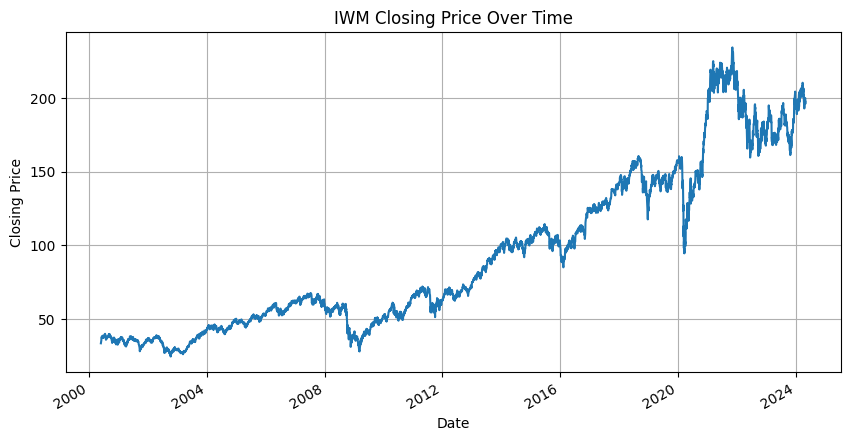

In [5]:
# Plotting closing price over time
iwm_data['Close'].plot(figsize=(10, 5))
plt.title('IWM Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

**Observations:** The IWM Closing Price chart from 2000 to 2024 shows a general upward trend with significant volatility around the 2008 financial crisis and 2020 pandemic. Despite periodic declines, the long-term trajectory indicates robust growth, highlighting the resilience and potential of small-cap stocks.

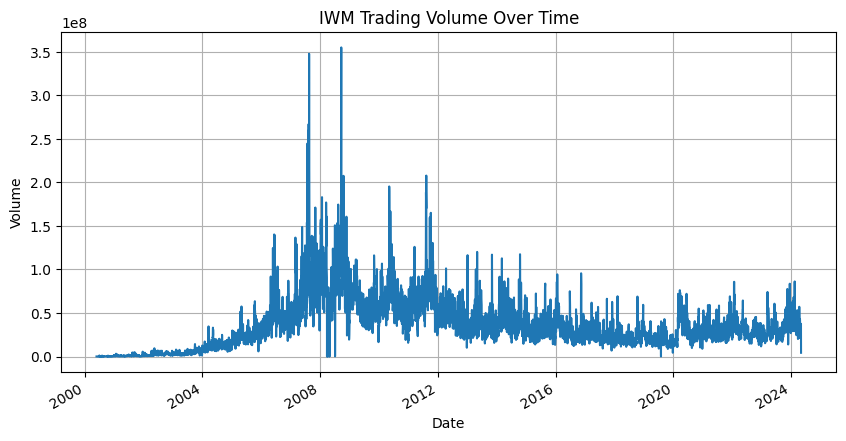

In [6]:
# Plotting volume
iwm_data['Volume'].plot(figsize=(10, 5))
plt.title('IWM Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

**Observations:** The IWM Trading Volume chart shows peaks during the 2008 financial crisis and less pronounced spikes through 2012, followed by more consistent, albeit lower, volumes post-2016. This suggests heightened trading activity during major market events, stabilizing in more recent years.

/Users/johri/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


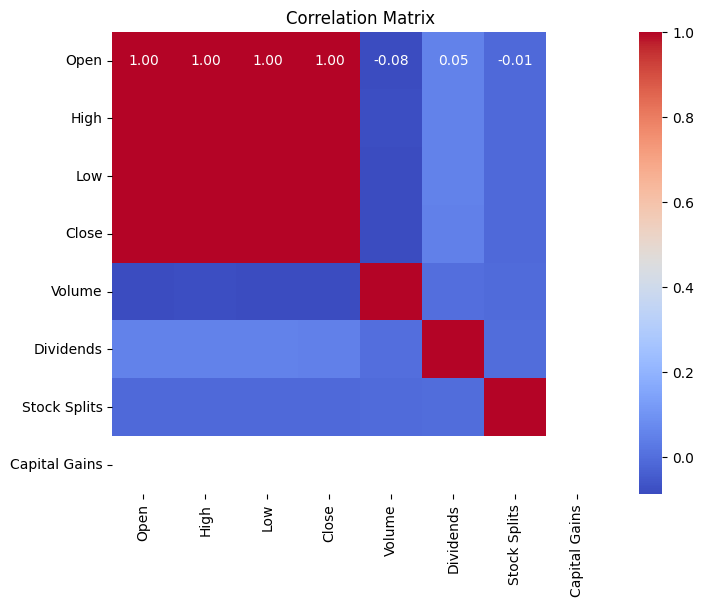

In [7]:
# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(iwm_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Observations:** The correlation matrix highlights strong positive correlations among Open, High, Low, and Close prices. Volume shows low correlation with these prices, while dividends and stock splits have minimal relationships with other variables. Capital gains and target metrics show generally weak correlations across all categories.

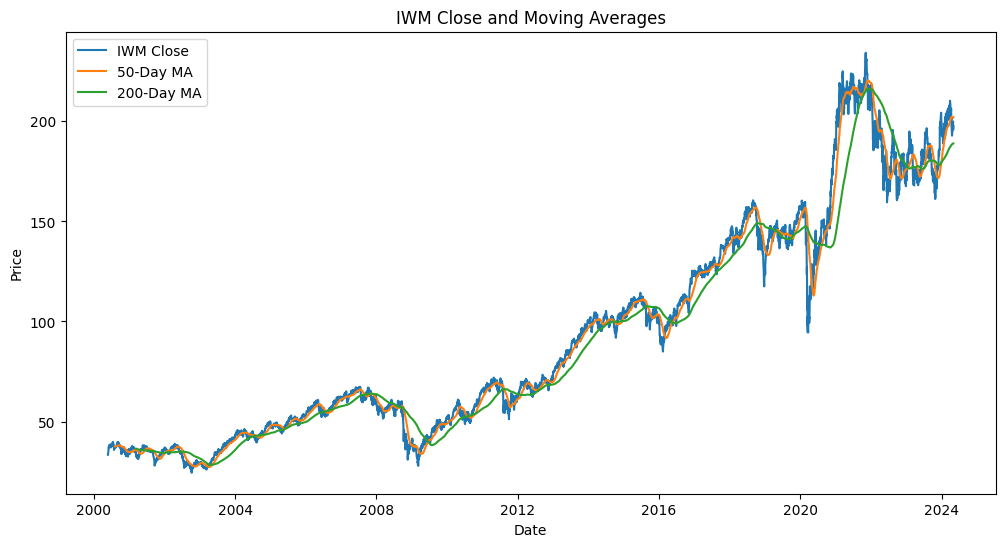

In [8]:
iwm_data['MA50'] = iwm_data['Close'].rolling(window=50).mean()
iwm_data['MA200'] = iwm_data['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(iwm_data['Close'], label='IWM Close')
plt.plot(iwm_data['MA50'], label='50-Day MA')
plt.plot(iwm_data['MA200'], label='200-Day MA')
plt.title('IWM Close and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Observations:** The chart of IWM's closing price with 50-day and 200-day moving averages shows consistent long-term growth, with moving averages indicating trend direction and potential buy/sell signals. Notably, sharp fluctuations around 2008 and 2020 reflect market crises, with quick recoveries highlighting resilience.

/Users/johri/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


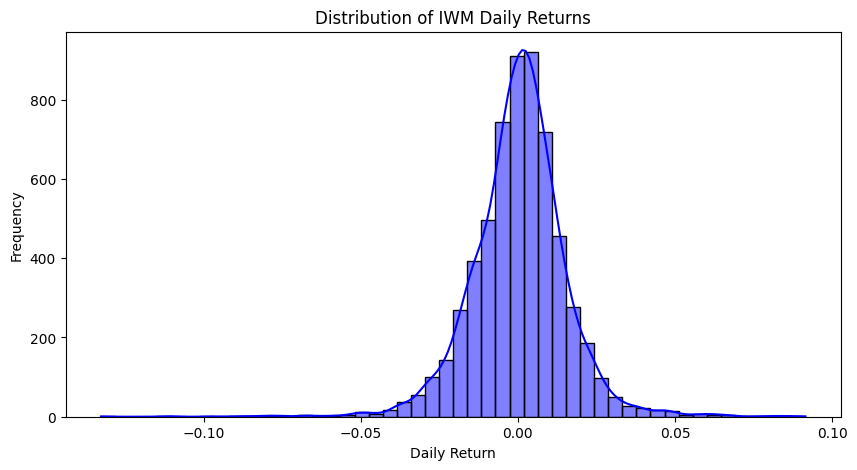

In [9]:
# Calculating daily returns
iwm_data['Daily Return'] = iwm_data['Close'].pct_change()
# Plotting the distribution of daily returns
plt.figure(figsize=(10, 5))
sns.histplot(iwm_data['Daily Return'].dropna(), bins=50, color='blue', kde=True)
plt.title('Distribution of IWM Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

**Observations:** The distribution of IWM's daily returns shows a near-normal distribution centered around zero, indicating consistent day-to-day price changes with most returns clustered close to no change. The symmetry suggests balanced upward and downward movements without extreme outliers, typical for a liquid, well-traded ETF.

/var/folders/9w/l4rxxlcs4cb1j7d8yw23854m0000gp/T/ipykernel_85533/3435596289.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = iwm_data['Close'].resample('Y').mean()
/var/folders/9w/l4rxxlcs4cb1j7d8yw23854m0000gp/T/ipykernel_85533/3435596289.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = iwm_data['Close'].resample('Y').ffill().pct_change()


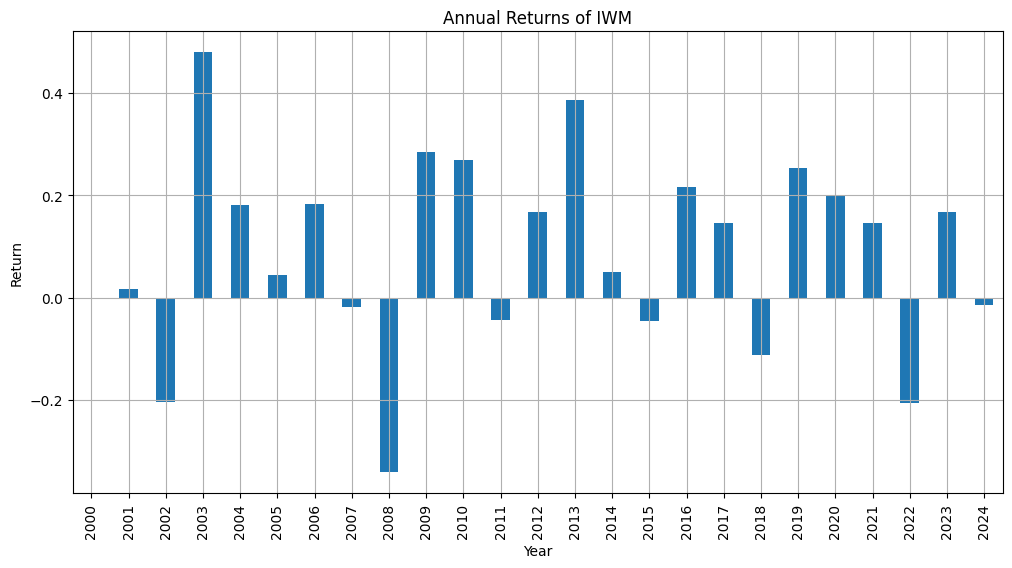

In [10]:
import matplotlib.pyplot as plt

# Assume iwm_data has already been defined and imported
# Extract year from the index
iwm_data['Year'] = iwm_data.index.year

# Calculate yearly price averages and performance
yearly_data = iwm_data['Close'].resample('Y').mean()
yearly_returns = iwm_data['Close'].resample('Y').ffill().pct_change()

# Convert index to year for plotting
yearly_returns.index = yearly_returns.index.year

plt.figure(figsize=(12, 6))
yearly_returns.plot(kind='bar')
plt.title('Annual Returns of IWM')
plt.xlabel('Year')
plt.ylabel('Return')
plt.grid(True)
plt.show()


**Observations:** The chart shows the annual returns of IWM with a mix of positive and negative years, highlighting significant fluctuations. Notable downturns occur around 2008 and 2022, while strong positive returns are evident in the early 2000s and post-2008 recovery years, reflecting market volatility and recovery dynamics.

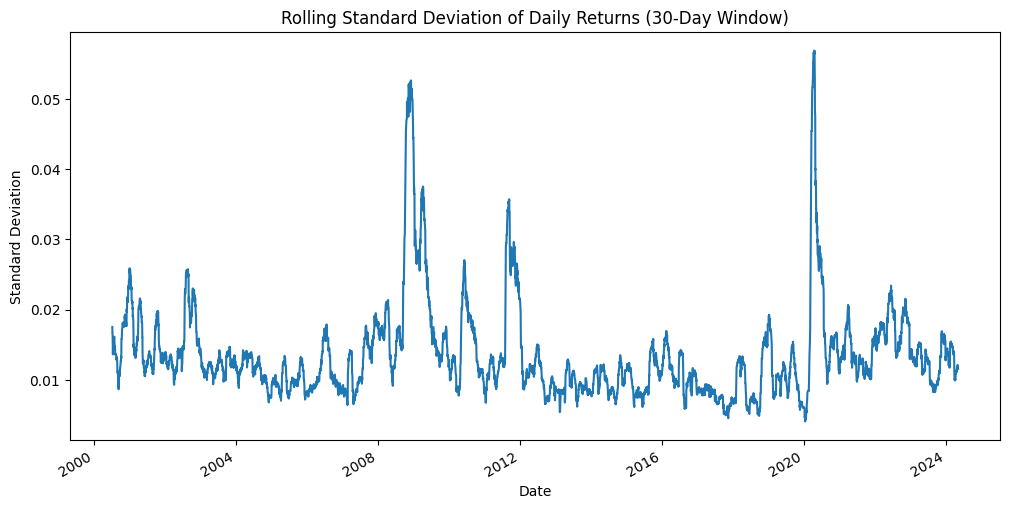

In [11]:
# Rolling standard deviation of daily returns to analyze volatility changes
iwm_data['Rolling Std 30'] = iwm_data['Daily Return'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
iwm_data['Rolling Std 30'].plot()
plt.title('Rolling Standard Deviation of Daily Returns (30-Day Window)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.show()

**Observations:** The chart of the rolling standard deviation of IWM daily returns shows spikes in volatility around 2008 and 2020, correlating with major financial crises, indicating higher market uncertainty. Periods of lower volatility suggest stable market conditions, predominantly post-2010 and before 2020.

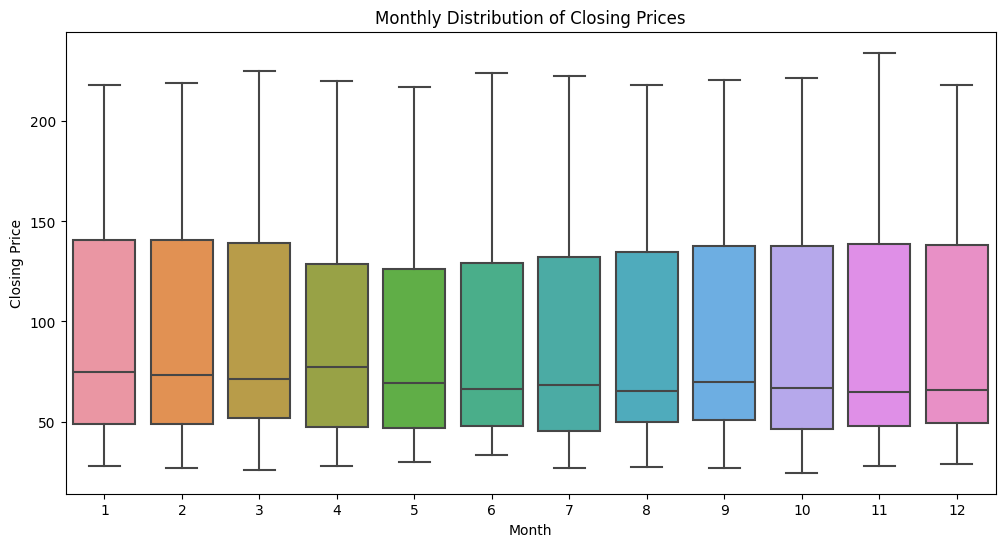

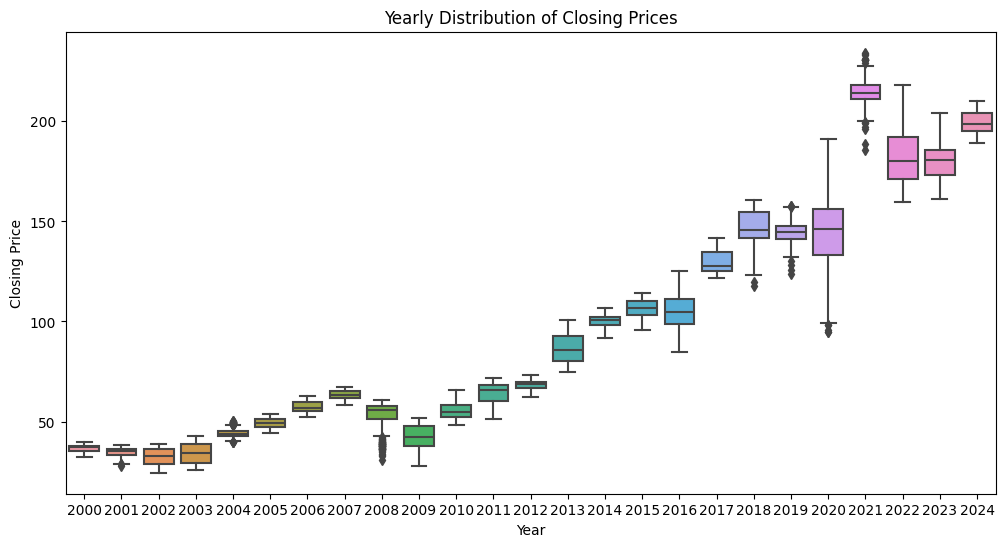

In [12]:
# Extract month for seasonal analysis
iwm_data['Month'] = iwm_data.index.month

# Box plot by month to observe seasonal effects
plt.figure(figsize=(12, 6))
sns.boxplot(data=iwm_data, x='Month', y='Close')
plt.title('Monthly Distribution of Closing Prices')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.show()

# Box plot by year to observe yearly volatility and range
plt.figure(figsize=(12, 6))
sns.boxplot(data=iwm_data, x='Year', y='Close')
plt.title('Yearly Distribution of Closing Prices')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

**Observations:**

**Monthly Distribution of Closing Prices:**
The monthly boxplots show that closing prices are relatively consistent throughout the year, with no significant seasonal trends indicated by the median lines. Variability seems slightly higher in some months, but overall, there are no drastic differences in price distributions across months.

**Yearly Distribution of Closing Prices:**
The yearly boxplots depict a general upward trend in IWM's closing prices over the years, with increased volatility and price ranges starting around 2020. Earlier years show more stable and compact price distributions, indicating less volatility. The widening of boxplots in recent years suggests greater price fluctuations and uncertainty.

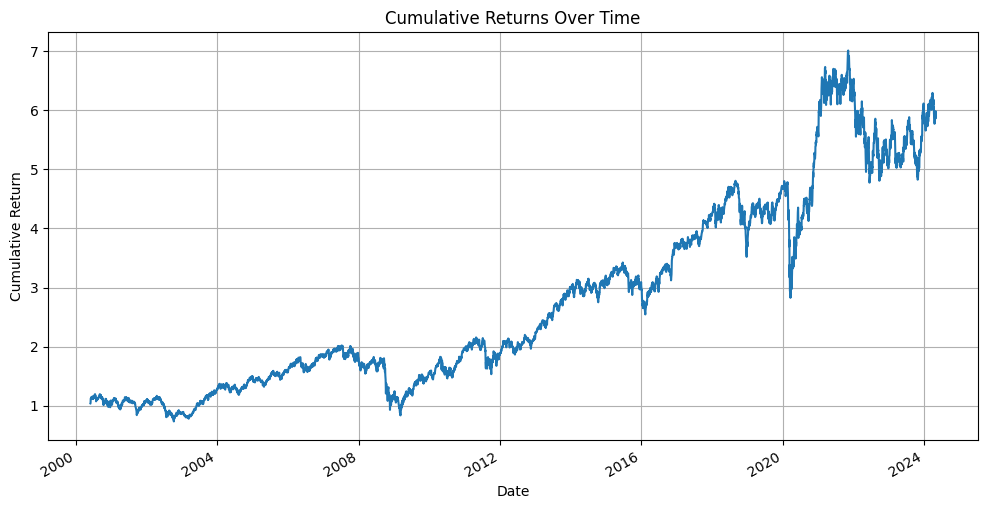

In [13]:
# Calculate cumulative returns
iwm_data['Cumulative Return'] = (1 + iwm_data['Daily Return']).cumprod()

plt.figure(figsize=(12, 6))
iwm_data['Cumulative Return'].plot()
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

**Observations:** The chart of cumulative returns for IWM shows robust long-term growth from 2000 to 2024, with significant accelerations post-2008 and 2020 crises. Periods of stability are evident between major growth spurts, highlighting resilience and recovery in response to economic downturns.

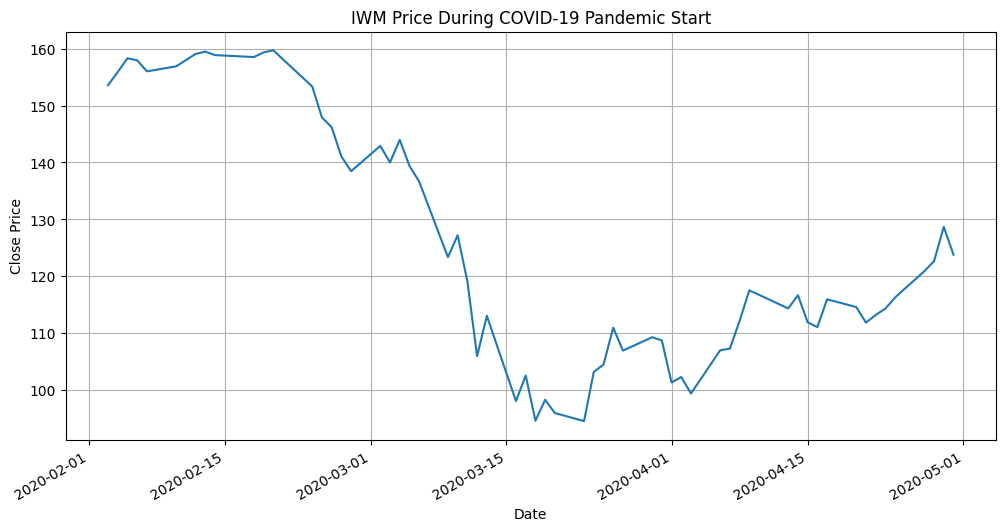

In [14]:
# Focusing on the 2020 pandemic effects
pandemic_start = '2020-02-01'
pandemic_end = '2020-04-30'

plt.figure(figsize=(12, 6))
iwm_data.loc[pandemic_start:pandemic_end, 'Close'].plot()
plt.title('IWM Price During COVID-19 Pandemic Start')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

**Observations:** The chart shows IWM's price during the early COVID-19 pandemic, displaying a sharp decline in March 2020 followed by a gradual recovery starting in April 2020. This illustrates the market's volatile reaction to the initial pandemic shock and subsequent rebound.

# Training with base Features

In [15]:
iwm_data['Target'] = (iwm_data['High'] >= 1.01 * iwm_data['Open']).astype(int)

In [16]:
# Function to create input features and target variable with sliding window of n days
def create_sliding_window(data, n):
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data.iloc[i:i+n].drop('Target', axis=1).values)
        y.append(data.iloc[i+n]['Target'])
    return np.array(X), np.array(y)

In [17]:
# Define window size
n_days = 3

# Create sliding window dataset
X, y = create_sliding_window(iwm_data[['Open', 'Close', 'High', 'Low', 'Volume', 'Target']], n_days)


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Flatten the input data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)


In [20]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/johri/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6576 - loss: 0.6521 - val_accuracy: 0.7010 - val_loss: 0.6027
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.6932 - loss: 0.6111 - val_accuracy: 0.7027 - val_loss: 0.5900
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.6970 - loss: 0.5925 - val_accuracy: 0.7051 - val_loss: 0.5871
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7097 - loss: 0.5871 - val_accuracy: 0.7085 - val_loss: 0.5819
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.7029 - loss: 0.5882 - val_accuracy: 0.7135 - val_loss: 0.5810
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.7118 - loss: 0.5809 - val_accuracy: 0.7093 - val_loss: 0.5792
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.6990 - loss: 0.5897 - val_accuracy: 0.7051 - val_loss: 0.5800
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.7132 - loss: 0.5712 - va

In [22]:
# Predict probabilities for the test set
probabilities = model.predict(X_test_scaled)

# Threshold for entering a trade
threshold = 0.6

# Make trading decisions based on predicted probabilities
trades = []
for prob in probabilities:
    if prob > threshold:
        trades.append(1)  # Enter trade
    else:
        trades.append(0)  # Do not enter trade

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


In [23]:
y_test.shape

(1204,)

In [24]:
# Evaluate the model
accuracy = np.mean(trades == y_test)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.7034883720930233


In [25]:
probabilities

array([[0.274493  ],
       [0.35215545],
       [0.32182238],
       ...,
       [0.3469044 ],
       [0.15391448],
       [0.4405192 ]], dtype=float32)

# Adding Macro-economic Features

In [33]:
#!pip install fredapi

In [36]:
import pandas as pd
from fredapi import Fred

# Setup FRED API
api_key = ''  # Replace this with your actual FRED API key
fred = Fred(api_key=api_key)

# Function to fetch data from FRED
def fetch_fred_series(series_id, start_date, end_date):
    data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    return data

# Load your ETF data
file_path = 'IWM_2001-2024.csv'
iwm_data = pd.read_csv(file_path)
iwm_data['Date'] = pd.to_datetime(iwm_data['Date'])

# Create a YearMonth column for merging
iwm_data['YearMonth'] = iwm_data['Date'].dt.to_period('M')

# Define the date range based on your dataset
start_date = iwm_data['Date'].min().strftime('%Y-%m-%d')
end_date = iwm_data['Date'].max().strftime('%Y-%m-%d')

# Fetch and prepare economic data
def prepare_and_fetch(series_id, value_name):
    data = fetch_fred_series(series_id, start_date, end_date)
    df = data.reset_index()
    df.columns = ['Date', value_name]
    df['YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
    return df[['YearMonth', value_name]]

# Prepare all dataframes
interest_rate_df = prepare_and_fetch('FEDFUNDS', 'Interest Rate')
cpi_df = prepare_and_fetch('CPIAUCSL', 'CPI')
gdp_df = prepare_and_fetch('GDP', 'GDP')
unemployment_df = prepare_and_fetch('UNRATE', 'Unemployment Rate')

# Merge all data into one DataFrame
from functools import reduce

dfs = [iwm_data, interest_rate_df, cpi_df, gdp_df, unemployment_df]
merged_data = reduce(lambda left, right: pd.merge(left, right, on='YearMonth', how='left'), dfs)

# Drop the YearMonth column if no longer needed
merged_data.drop(columns=['YearMonth'], inplace=True)

# Save the merged dataset
merged_data.to_csv('merged_data.csv', index=False)

print(merged_data.head())


        Date       Open       High        Low      Close  Adj Close  Volume  \
0 2001-04-02  44.775002  45.000000  43.674999  43.750000  32.299583  340200   
1 2001-04-03  43.650002  43.650002  42.125000  42.264999  31.203249  507400   
2 2001-04-04  42.325001  42.924999  42.200001  42.400002  31.302916  356400   
3 2001-04-05  43.000000  44.450001  43.000000  44.450001  32.816372  950000   
4 2001-04-06  43.750000  43.889999  43.125000  43.200001  31.893551  405000   

   Interest Rate    CPI      GDP  Unemployment Rate  
0            4.8  176.4  10599.0                4.4  
1            4.8  176.4  10599.0                4.4  
2            4.8  176.4  10599.0                4.4  
3            4.8  176.4  10599.0                4.4  
4            4.8  176.4  10599.0                4.4  


In [37]:
merged_data['Target'] = (merged_data['High'] >= 1.01 * merged_data['Open']).astype(int)
merged_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Interest Rate,CPI,GDP,Unemployment Rate,Target
0,2001-04-02,44.775002,45.000000,43.674999,43.750000,32.299583,340200,4.8,176.4,10599.0,4.4,0
1,2001-04-03,43.650002,43.650002,42.125000,42.264999,31.203249,507400,4.8,176.4,10599.0,4.4,0
2,2001-04-04,42.325001,42.924999,42.200001,42.400002,31.302916,356400,4.8,176.4,10599.0,4.4,1
3,2001-04-05,43.000000,44.450001,43.000000,44.450001,32.816372,950000,4.8,176.4,10599.0,4.4,1
4,2001-04-06,43.750000,43.889999,43.125000,43.200001,31.893551,405000,4.8,176.4,10599.0,4.4,0


## Neural Network
In this part we also use the macro-economic features.

In [38]:
# Define window size
n_days = 3

# Create sliding window dataset
X, y = create_sliding_window(merged_data[['Open', 'Close', 'High', 'Low', 'Volume', 'Target', 'Interest Rate',	'CPI',	'GDP',	'Unemployment Rate']], n_days)


In [39]:
""
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [40]:
# Flatten the input data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)


In [41]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/johri/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10


145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6983 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.6974 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.7040 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7096 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.6987 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.7005 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.6913 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.6919 - loss: nan - val_accuracy: 0.6949 - val_loss: nan
Epoch 9/10
145/145 ━━

In [43]:
# Predict probabilities for the test set
probabilities = model.predict(X_test_scaled)

# Threshold for entering a trade
threshold = 0.6

# Make trading decisions based on predicted probabilities
trades = []
for prob in probabilities:
    if prob > threshold:
        trades.append(1)  # Enter trade
    else:
        trades.append(0)  # Do not enter trade

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step


In [44]:
y_test.shape

(1157,)

In [45]:
# Evaluate the model
accuracy = np.mean(trades == y_test)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.6949006050129646
